# Solution of a simple truss by FEM using SolidsPy

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque and Universidad EAFIT.

This notebook is a modified and extended version of the [original one](https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/examples/simple_truss/simple_truss.ipynb) by Guarín-Zapata and Gómez in the   [SolidsPy repo](https://github.com/AppliedMechanics-EAFIT/SolidsPy).

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_solid_mechanics/blob/main/notebooks/simple_truss.ipynb).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* And other packages for general scientific programming in Python


## Setting up the environment

### Required modules and setup for plots

In [1]:
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
    print('Running on CoLab. Installing the required modules...')
    !apt-get update -qq && apt-get install -y libglu1-mesa -y &> ~/apt-log.txt
    %pip install solidspy==1.0.16 &> ~/pip-log.txt
    %pip install ipympl &> ~/pip-log.txt &> ~/pip-log.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from ipywidgets import widgets as wgt
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol
import solidspy.uelutil as uel
from IPython.display import display

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'


## SolidsPy's inputs

<div style="background-color: white; padding: 10px;">
    <img src="../figs/simple_truss.svg" height="400" frameborder="0" ></iframe>
</div>

### Global inputs

In [2]:
# Geometry
l1 = 10  # [m]
l2 = 5  # [m]
l0 = l1*np.cos(np.deg2rad(30))  # [m]
A = 1e-2  # Cross-sectional area of the bars [m]

# Material properties
elastic_mod = 1e6  # [N]

# Loads
load = -10  # [N]


### Nodes

**Notes:**
- Global coordinates with origin in the bottom left corner of the truss, i.e., at node 2.
- For defining constraints, -1 means constrained, and 0 is unconstrained.

In [3]:
nodes = pd.DataFrame(
    {
    'node_id': (0, 1, 2),
    'coord_x': (l0, 0, 0),
    'coord_y': (0, l2, 0),
    'cons_x': (0, -1, -1),
    'cons_y': (0, 0, -1)
    }
)
nodes


,node_id,coord_x,coord_y,cons_x,cons_y
0,0,8.660254,0,0,0
1,1,0.000000,5,-1,0
2,2,0.000000,0,-1,-1


### Materials
All the bars are made of the same material and cross-sectional area. However, assigning different materials and cross-sectional areas for each bar in the code below is possible.

In [4]:
mats = pd.DataFrame(
    {
    'elem_id': (0, 1, 2),
    'elast_mod': (elastic_mod, elastic_mod, elastic_mod),
    'area': (A, A, A)
    }
)
mats


,elem_id,elast_mod,area
0,0,1000000.0,0.01
1,1,1000000.0,0.01
2,2,1000000.0,0.01


### Elements conectivity

In [5]:
elems = pd.DataFrame(
    {
    'elem_id': (0, 1, 2),
    'elem_type': (6, 6, 6),
    'mat_profile': (0, 1, 2),
    'elem_ini': (2, 0, 1),
    'elem_end': (0, 1, 2),
    }
)
elems


,elem_id,elem_type,mat_profile,elem_ini,elem_end
0,0,6,0,2,0
1,1,6,1,0,1
2,2,6,2,1,2


### Loads

In [6]:
loads = pd.DataFrame(
    {
    'node_id': (0,),
    'force_x': (0,),
    'force_y': (load,)
    }
)
loads


,node_id,force_x,force_y
0,0,0,-10


In [7]:
# Inputs to arrays
nodes = nodes.to_numpy()
mats = mats.to_numpy()[:, 1:]
elems = elems.to_numpy()
loads = loads.to_numpy()


## Local stifness matrices

For the problem at hand, the local stiffness matrix for each element $K_i$ is given by:

$$K_0 = \frac{2000}{\sqrt{3}}\begin{bmatrix}
1 &0 &-1 &0\\
0 &0 &0 &0\\
1 &0 &-1 &0\\
0 &0 &0 &0\end{bmatrix}$$

$$K_1 = 250\begin{bmatrix}
3 &-\sqrt{3} &-3 &\sqrt{3}\\
\sqrt{3} &1 &\sqrt{3} &-1\\
-3 &\sqrt{3} &3 &-\sqrt{3}\\
\sqrt{3} &-1 &-\sqrt{3} &1\end{bmatrix}$$

$$K_2 = 2000\begin{bmatrix}
0 &0 &0 &0\\
0 &1 &0 &1\\
0 &0 &0 &0\\
0 &-1 &0 &1\end{bmatrix}$$

This can be double-checked by using SolidsPy:

In [8]:
for el in range(3):
    coords = nodes[elems[el, 3:], 1:3]
    E, A = mats[el]
    # print(coords, E, A, sep="\n", end="\n\n")
    K_local = uel.ueltruss2D(coords, A, E)
    print(f"Element {el} -- K (local)", np.round(K_local), sep="\n", end="\n\n")


Element 0 -- K (local)
[[ 1155.     0. -1155.     0.]
 [    0.     0.     0.     0.]
 [-1155.     0.  1155.     0.]
 [    0.     0.     0.     0.]]

Element 1 -- K (local)
[[ 750. -433. -750.  433.]
 [-433.  250.  433. -250.]
 [-750.  433.  750. -433.]
 [ 433. -250. -433.  250.]]

Element 2 -- K (local)
[[    0.     0.     0.     0.]
 [    0.  2000.     0. -2000.]
 [    0.     0.     0.     0.]
 [    0. -2000.     0.  2000.]]



## Global stiffness matrix

### Unconstrained matrix


$$K_\text{total} = 250 \begin{bmatrix}
\frac{8}{\sqrt{3}} + 3 &-\sqrt{3} &3 &\sqrt{3} &-\frac{8}{\sqrt{3}} &0\\
-\sqrt{3} &1 &\sqrt{3} &-1 &0 &0\\
3 &\sqrt{3} &3 &-\sqrt{3} &0 &0\\
\sqrt{3} &-1 &-\sqrt{3} &9 &0 &-8\\
-\frac{8}{\sqrt{3}} &0 &0 &0 &\frac{8}{\sqrt{3}} &0\\
0 &0 &0 &-8 &0 &8
\end{bmatrix}$$


In [9]:
# Create a unconstrained nodes array
nodes_uncon = nodes.copy()
nodes_uncon[:, 3:] = 0  # Remember that zero means unconstrained

# Get the assembly operator, boundary conditions array and No. of active equations in the system
DME , IBC , neq = ass.DME(nodes_uncon, elems)

# Assambly the global unconstrained stiffness matrix
K_global_uncon = ass.assembler(elems, mats, nodes_uncon, neq, DME, sparse=False)
print(np.round(K_global_uncon))


[[ 1905.  -433.  -750.   433. -1155.     0.]
 [ -433.   250.   433.  -250.     0.     0.]
 [ -750.   433.   750.  -433.     0.     0.]
 [  433.  -250.  -433.  2250.     0. -2000.]
 [-1155.     0.     0.     0.  1155.     0.]
 [    0.     0.     0. -2000.     0.  2000.]]


### Constrained matrix

$$K_\text{total}^\text{cons} = 250 \begin{bmatrix}
\frac{8}{\sqrt{3}} + 3 &-\sqrt{3} &\sqrt{3}\\
-\sqrt{3} &1  &-1 \\
\sqrt{3} &-1 &9\\
\end{bmatrix}$$


In [10]:
# Get the assembly operator, boundary conditions array and No. of active equations in the system
DME , IBC , neq = ass.DME(nodes, elems)
# Assemble the global unconstrained stiffness matrix
K_global = ass.assembler(elems, mats, nodes, neq, DME, sparse=False)
print(np.round(K_global))


[[1905. -433.  433.]
 [-433.  250. -250.]
 [ 433. -250. 2250.]]


### Right-hand-side (rhs) vector of the equation to solve

In [11]:
# Assemble the right-hand-side vector of the equation
load_vec = ass.loadasem(loads, IBC, neq)
print(load_vec)


[  0. -10.   0.]


## Solve the system of equations

In [12]:
# Solve a static problem [mat]{u_sol} = {rhs}
disp_ = sol.static_sol(K_global, load_vec)
print(disp_)


[-0.015      -0.07098076 -0.005     ]


In [13]:
# Complete the displacement vectors with imposed and computed values
disp = pos.complete_disp(IBC, nodes, disp_)
print(disp)


[[-0.015      -0.07098076]
 [ 0.         -0.005     ]
 [ 0.          0.        ]]


## Visualize the results

In [14]:
def plot_def_undef_truss(loads, nodes, disp, xfactor=5, widget=False, **kwargs):
    figsize = kwargs.get('figsize', [6.5, 4])
    x_node, y_node = nodes[:, 1:3].T
    x_def, y_def = nodes[:, 1:3].T + xfactor * disp.T
    x_node = np.hstack((x_node, x_node[0]))
    y_node = np.hstack((y_node, y_node[0]))
    x_def = np.hstack((x_def, x_def[0]))
    y_def = np.hstack((y_def, y_def[0]))
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, layout='constrained')
    # Cosntraints
    x_res, y_res = nodes[1:, 1:3].T
    ax.plot(x_res, y_res, ls="", marker=5, ms=10, c='k', fillstyle='full')
    x_res, y_res = nodes[2:, 1:3].T
    ax.plot(x_res, y_res, ls="", marker=6, ms=10, c='k', fillstyle='full')
    # Truss
    ax.plot(x_node, y_node, ls="-", marker=".", lw=1.5, ms=7, c="b",
            label='Undeformed truss')
    ax.plot(x_def, y_def, ls="--", marker='o', lw=1.5, ms=7, c="r", fillstyle='none',
            label=f'Deformed truss ({xfactor}x)')
    # Load
    x_load, y_load = nodes[0][1:3]
    dy = .2 * (max(y_node) - min(y_node))
    if loads[0, -1] > 0:
        dy *= -1
    ax.arrow(x_load, y_load+dy, dx=0, dy=-dy, width=.05,  fc='k', ec='k',
             length_includes_head=True)
    # Format
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=kwargs.get('title'))
    ax.legend(loc='best')
    ax.axis("image")
    ax.set(xlabel='$x$  [m]', ylabel='$y$  [m]')
    if widget:
        display(fig)
    else:
        plt.show()
        display(wgt.HTML(html_setup))
    plt.close()
    return


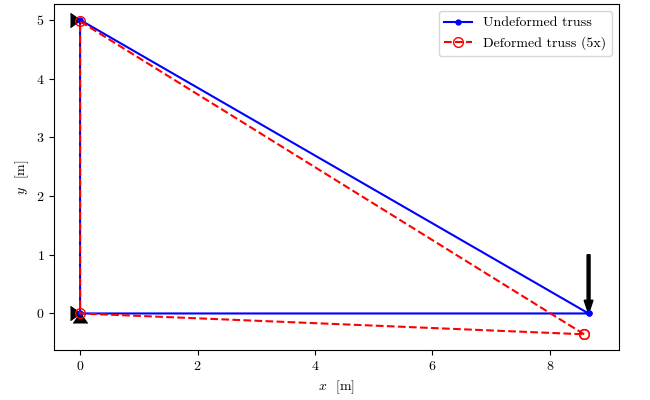

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [15]:
plot_def_undef_truss(loads, nodes, disp)


## Interactive plots

In [16]:
def interactive_solution(l0, l2, A, load, E, xfactor=5, widget=False):
    nodes = np.array([[0, l0, 0, 0, 0], [1, 0, l2, -1, 0], [2, 0, 0, -1, -1]])
    mats = np.array([[0, E, A], [1, E, A], [2, E, A]])[:, 1:]
    elems = np.array([[0, 6, 0, 2, 0], [1, 6, 1, 0, 1], [2, 6, 2, 1, 2]])
    loads = np.array([[0, 0, load]])
    # Get the assembly operator, boundary conditions array and No. of active equations in the system
    DME , IBC , neq = ass.DME(nodes, elems)
    # Assemble the global unconstrained stiffness matrix
    K_global = ass.assembler(elems, mats, nodes, neq, DME, sparse=False)
    # Assemble the right-hand-side vector of the equation
    load_vec = ass.loadasem(loads, IBC, neq)
    # Solve a static problem [mat]{u_sol} = {rhs}
    disp_ = sol.static_sol(K_global, load_vec)
    # Complete the displacement vectors with imposed and computed values
    disp = pos.complete_disp(IBC, nodes, disp_)

    # Plot
    plot_def_undef_truss(loads, nodes, disp, xfactor=xfactor, widget=widget)

# interactive_solution(l0, l2, A, load, E, xfactor=10)


In [17]:
s, l = {'description_width': '50px'}, wgt.Layout(width='300px')
controls = {
    'l0': wgt.FloatSlider(value=8.66, min=.1, max=50, step=.5, description="L0 [m]", style=s, layout=l),
    'l2': wgt.FloatSlider(value=5.0, min=.1, max=50, step=.5, description="L2 [m]", style=s, layout=l),
    'A': wgt.FloatLogSlider(value=0.01, min=-5, max=1, step=.001, description="A [m²]", style=s, layout=l),
    'load': wgt.FloatSlider(value=-10, min=-100, max=100, step=1, description="Load [N]", style=s, layout=l),
    'E': wgt.FloatLogSlider(value=1e6, min=3, max=10, step=.1, description="E [Pa]", style=s, layout=l),
    'xfactor': wgt.FloatSlider(value=5, min=1, max=50, step=.1, description="x factor", style=s, layout=l),
    'widget': wgt.Checkbox(value=True, description='Check to improve widget performance', disabled=False, style=s, layout=l),
}
fig = wgt.interactive_output(interactive_solution, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))
